In [1]:
import geopandas as gpd
import json
import libpysal
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns

import os
os.chdir("../")
from adjustText import adjust_text
from epitools import get_data
from scipy.stats import kendalltau, pearsonr

In [2]:
country = "Chile"
year = 2021
location_level = "region_id"

colors = json.load(open("consts.json", encoding="utf-8"))

In [3]:
gdf = gpd.read_file("geo_shapes/Chile_region.geojson")
gdf = gdf.rename(columns={"codregion": "region_id"})
# gdf.to_file("Chile.gpkg", driver="GPKG")
gdf.head()

,fid,objectid,cir_sena,region_id,area_km,st_area_sh,st_length_,Region,geometry
0,1,1084,1,15,16866.8198,1.886869e+10,7.505296e+05,Región de Arica y Parinacota,"POLYGON ((-69.41530 -17.65520, -69.33660 -17.7..."
1,2,1085,2,1,42284.5674,4.830637e+10,1.213713e+06,Región de Tarapacá,"MULTIPOLYGON (((-70.16030 -20.21070, -70.16020..."
2,3,1086,3,2,126071.4319,1.508452e+11,2.516112e+06,Región de Antofagasta,"MULTIPOLYGON (((-70.70160 -25.89170, -70.70050..."
3,4,1087,15,12,133053.1423,3.581316e+11,9.049830e+07,Región de Magallanes y Antártica Chilena,"MULTIPOLYGON (((-67.32020 -55.92010, -67.24870..."
4,5,1088,14,11,106703.3773,2.242743e+11,4.144481e+07,Región de Aysén del Gral.Ibañez del Campo,"MULTIPOLYGON (((-75.57990 -48.75890, -75.58030..."


In [4]:
# gdf = gpd.read_file("geo_shapes/Chile_provinces.zip")
# gdf["Provincia"] = gdf["Provincia"].str.upper().str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")
# gdf = gdf.rename(columns={"Provincia": "province"})
# gdf.head()

In [5]:
method = "nv"
df = pd.read_csv(f"data_output/{country}/{year}_divisiveness_{location_level}_{method}_runoff.csv.gz", compression="gzip")

df.head()

,candidate,value,weight,type,region_id
0,GABRIEL BORIC FONT,0.452191,0.486803,Between,1
1,JOSE ANTONIO KAST RIST,0.442709,0.513197,Between,1
2,GABRIEL BORIC FONT,0.048150,0.486803,Within,1
3,JOSE ANTONIO KAST RIST,0.054929,0.513197,Within,1
4,GABRIEL BORIC FONT,0.388682,0.597877,Between,2


In [6]:
df_fround = pd.read_csv(f"data_output/{country}/{year}_first_round.csv.gz", compression="gzip")
df_fround.columns = [x.lower() for x in df_fround.columns]

df_runoff = pd.read_csv(f"data_output/{country}/{year}_runoff.csv.gz", compression="gzip")
df_runoff.columns = [x.lower() for x in df_runoff.columns]

candidate_a, candidate_b = df_runoff.candidate.unique()
df_location = pd.read_csv(f"data_output/{country}/{year}_first_round_location.csv.gz", compression="gzip")

df_fround = pd.merge(df_fround, df_location, on="polling_id")
df_runoff = pd.merge(df_runoff, df_location, on="polling_id")


In [7]:
data = pd.merge(gdf, df, on=location_level)
data.head()

,fid,objectid,cir_sena,region_id,area_km,st_area_sh,st_length_,Region,geometry,candidate,value,weight,type
0,1,1084,1,15,16866.8198,1.886869e+10,7.505296e+05,Región de Arica y Parinacota,"POLYGON ((-69.41530 -17.65520, -69.33660 -17.7...",GABRIEL BORIC FONT,0.455789,0.506081,Between
1,1,1084,1,15,16866.8198,1.886869e+10,7.505296e+05,Región de Arica y Parinacota,"POLYGON ((-69.41530 -17.65520, -69.33660 -17.7...",JOSE ANTONIO KAST RIST,0.453564,0.493919,Between
2,1,1084,1,15,16866.8198,1.886869e+10,7.505296e+05,Región de Arica y Parinacota,"POLYGON ((-69.41530 -17.65520, -69.33660 -17.7...",GABRIEL BORIC FONT,0.043033,0.506081,Within
3,1,1084,1,15,16866.8198,1.886869e+10,7.505296e+05,Región de Arica y Parinacota,"POLYGON ((-69.41530 -17.65520, -69.33660 -17.7...",JOSE ANTONIO KAST RIST,0.046342,0.493919,Within
4,2,1085,2,1,42284.5674,4.830637e+10,1.213713e+06,Región de Tarapacá,"MULTIPOLYGON (((-70.16030 -20.21070, -70.16020...",GABRIEL BORIC FONT,0.452191,0.486803,Between


In [8]:
output = []

for year in [2013, 2017, 2021]:
    df = get_data(
        country="Chile",
        year=year,
        aggregation="region_id",
        election="first_round",
        method="nv"
    )
    
    output.append(df)
    
df_dv = pd.concat(output, ignore_index=True)
df_dv["region_id"] = df_dv["region_id"].astype(int)
df_dv.head()

,region_id,epi,epi_between,epi_within,year
0,1,0.920884,0.846443,0.074441,2013
1,10,0.810297,0.725631,0.084667,2013
2,11,0.814239,0.739069,0.075170,2013
3,12,0.848584,0.775496,0.073088,2013
4,13,0.870222,0.748058,0.122164,2013


## Creates Map
For 2013, 2017, 2021 elections

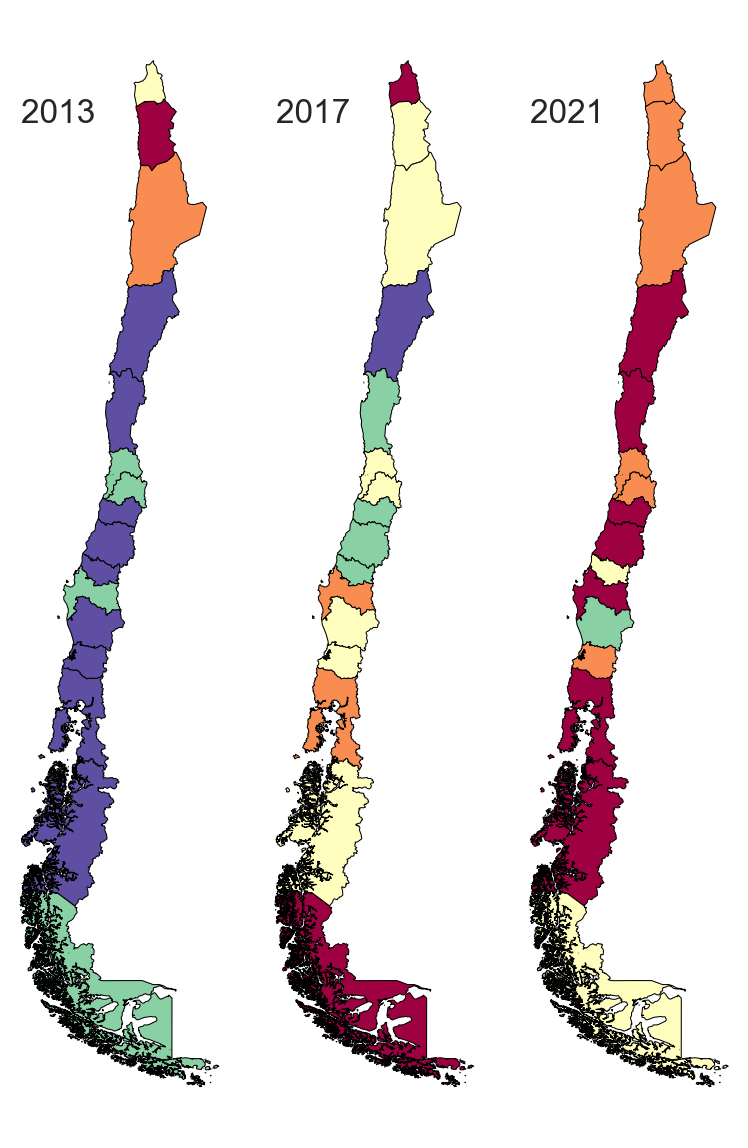

In [19]:
measure_name = "epi"
cmap = {"epi_between": "YlGn", "epi_within": "YlGnBu", "epi": "Spectral_r"}
df_dv["vl"] = pd.qcut(df_dv[measure_name].copy(), 5)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 20), dpi=100)
sns.set(font_scale=2)
def set_corr(corr, _):
    corr = round(corr, 3)
    if _ < 0.01:
        return f"ρ={corr}***"
    elif _ < 0.05:
        return f"ρ={corr}**"
    elif _ < 0.1:
        return f"ρ={corr}*"
    return f"ρ={corr}"

dd = df_dv.pivot_table(index="region_id", columns="year", values=measure_name).reset_index()
dd.columns = ["region_id", 2013, 2017, 2021]
years = list(df_dv.year.unique())
corr_year = dd.values

for idx, year in enumerate(df_dv.year.unique()):
    data_tmp = df_dv[df_dv["year"] == year]
    data_tmp = pd.merge(data_tmp, gdf, on="region_id")
    ax = axs[idx]
    W = libpysal.weights.Queen.from_dataframe(data_tmp)
    W.transform = "r"
    data_tmp["sp_value"] = libpysal.weights.lag_spatial(W, data_tmp[measure_name])

    data_tmp = gpd.GeoDataFrame(data_tmp).dropna()

    data_tmp.plot(
        column="vl",
        edgecolor="black",
        # vmin=df_dv[measure_name].min(),
        # vmax=df_dv[measure_name].max(),
        lw=0.75,
        ax=ax, 
        cmap=cmap[measure_name],
        legend=False, 
        legend_kwds=dict(
            shrink=0.075
        )
    )

    corr, _ = pearsonr(data_tmp[measure_name], data_tmp["sp_value"])
    # ax.text(0.05, 0.96, set_corr(corr, _), color="green", transform=ax.transAxes)

    # if year > 2013:
    #     value = corr_year[years.index(year - 4), years.index(year)]
    #     tmp = dd[[year - 4, year]].copy().dropna()
    #     corr, _ = pearsonr(tmp[year - 4], tmp[year])
    #     ax.text(0.05, 0.99, set_corr(corr, _), color="blue", transform=ax.transAxes)

    axs[idx].axis("off")
    ax.text(0.05, 0.9, year, transform=ax.transAxes)

fig.tight_layout()

In [10]:
categories = df_dv["vl"].sort_values().unique()

for idx, vl in enumerate(categories):
    if idx == 0:
        print(f"<{vl.right}")
    elif idx == len(categories) - 1:
        print(f">{vl.left}")
    else:
        print(f"{vl.left}-{vl.right}")

<0.0711
0.0711-0.0772
0.0772-0.0826
0.0826-0.0909
>0.0909


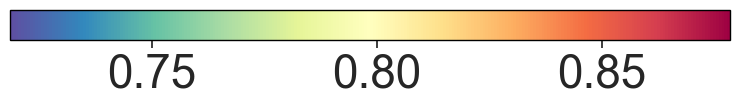

In [11]:
import pylab as pl
import numpy as np

measure_name = "epi_between"

sns.set(font_scale=3)
a = np.array([[df_dv[measure_name].min(), df_dv[measure_name].max()]])
pl.figure(figsize=(9, 1.5))
img = pl.imshow(a, cmap="Spectral_r")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.2])



cb = pl.colorbar(orientation="horizontal", cax=cax)
# cb.ax.set_xticklabels(["<0.2", "0.25", "0.3", "0.35", "0.4+"])
cb.outline.set_color("#000000")
cb.outline.set_linewidth(1)

In [12]:
# dd = pd.merge(df_fround, df_runoff, on=["polling_id", "candidate"])
# dd = dd.pivot_table(index="polling_id", columns=["candidate"], values=["rate_x", "rate_y"])
# dd = dd.reset_index()
# dd.columns = [f"{a}{b}" for a, b in dd.columns]

# dd["winner"] = dd.apply(lambda x: \
#                         candidate_a if x[f"rate_x{candidate_a}"] > x[f"rate_x{candidate_b}"] else candidate_b, axis=1)
# dd["loser"] = dd.apply(lambda x: \
#                         candidate_a if x[f"rate_x{candidate_a}"] < x[f"rate_x{candidate_b}"] else candidate_b, axis=1)

# dd["rate_winner"] = dd.apply(lambda x: \
#                         x[f"rate_x{candidate_a}"] if x[f"rate_x{candidate_a}"] > x[f"rate_x{candidate_b}"] else x[f"rate_x{candidate_b}"], axis=1)
# dd["rate_loser"] = dd.apply(lambda x: \
#                         x[f"rate_x{candidate_a}"] if x[f"rate_x{candidate_a}"] < x[f"rate_x{candidate_b}"] else x[f"rate_x{candidate_b}"], axis=1)

# dd = pd.merge(dd, df_location, on="polling_id")

# dd = pd.merge(dd, df[["value", "candidate", location_level]].rename(columns={"value": "dv_winner"}), 
#               left_on=[location_level, "winner"], right_on=[location_level, "candidate"])
# dd = pd.merge(dd, df.rename(columns={"value": "dv_loser"}), 
#     left_on=[location_level, "loser"], right_on=[location_level, "candidate"])
# dd = pd.merge(dd, df_endorsement, on="polling_id")

# dd["en_winner"] = dd.apply(lambda x: \
#                         x[candidate_a] if x[f"rate_x{candidate_a}"] > x[f"rate_x{candidate_b}"] else x[candidate_b], axis=1)
# dd["en_loser"] = dd.apply(lambda x: \
#                         x[candidate_a] if x[f"rate_x{candidate_a}"] < x[f"rate_x{candidate_b}"] else x[candidate_b], axis=1)

# dd["dv_diff"] = dd["dv_winner"] - dd["dv_loser"]
# dd["rate_diff"] = dd["rate_winner"] - dd["rate_loser"]

# dd["flip"] = ((dd[f"rate_x{candidate_a}"] > dd[f"rate_x{candidate_b}"]) & (dd[f"rate_y{candidate_a}"] < dd[f"rate_y{candidate_b}"])) |\
#     ((dd[f"rate_x{candidate_b}"] > dd[f"rate_x{candidate_a}"]) & (dd[f"rate_y{candidate_b}"] < dd[f"rate_y{candidate_a}"]))

# # dd = pd.merge(dd, ee, on=[location_level])
# dd["flip"] = dd["flip"].astype(int)
# dd = pd.merge(
#     dd, 
#     dd.groupby(location_level).agg({"flip": "mean"}).reset_index().rename(columns={"flip": "flip_neighbors"}),
#     on=location_level
# )
# # dd = pd.merge(dd, cc[["polling_id", "diff_participation", "increase_participation"]], on="polling_id")
# dd.to_csv("test2.csv", index=False)

In [13]:
from data_curation import flip_df

In [14]:
# df_test = dd.copy()
# df_test["qdv_winner"] = pd.qcut(df_test["dv_winner"], 6).astype(str)
# df_test["qdv_loser"] = pd.qcut(df_test["dv_loser"], 6).astype(str)
# m = df_test.groupby(["qdv_winner", "qdv_loser"]).agg({"flip": "mean"}).reset_index()
# m = m.pivot(index="qdv_winner", columns="qdv_loser", values="flip")

# sns.set(font_scale=2)
# fig, ax = plt.subplots(figsize=(9.5, 8))
# g = sns.heatmap(m, cmap="plasma")
# g.invert_yaxis()
# g.set_xlabel("Divisiveness (%) Winner")
# g.set_ylabel("Divisiveness (%) Loser")
# g.set_xticklabels([])
# g.set_yticklabels([])
# g

In [15]:
# df_test = dd.copy().dropna()
# df_test["qdv_winner"] = pd.qcut(df_test["rate_winner"], 10).astype(str)
# df_test["qdv_loser"] = pd.qcut(df_test["rate_loser"], 10).astype(str)
# m = df_test.groupby(["qdv_winner", "qdv_loser"]).agg({"flip": "mean"}).reset_index()
# m = m.pivot(index="qdv_winner", columns="qdv_loser", values="flip")

# sns.set(font_scale=2)
# fig, ax = plt.subplots(figsize=(9.5, 8))
# g = sns.heatmap(m, cmap="plasma")
# g.invert_yaxis()
# g.set_xlabel("Rate (%) Winner")
# g.set_ylabel("Rate (%) Loser")
# g.set_xticklabels([])
# g.set_yticklabels([])
# g

In [16]:
df_geo = pd.read_excel(
    "https://repositoriodeis.minsal.cl/ContenidoSitioWeb2020/uploads/2019/11/DPA2018.xls",
    header=1
)
values = {
    "Código Comuna desde 2018": "commune_id",
    "Nombre Comuna": "commune",
    "Código Provincia desde 2018": "province_id",
    "Provincia desde 2018": "province",
    "Código Región desde 2018": "region_id",
    "Nombre Región desde 2018": "region"
}
df_geo = df_geo.rename(columns=values)
df_geo = df_geo[values.values()]
df_geo.head()

,commune_id,commune,province_id,province,region_id,region
0,15101,Arica,151,Arica,15,De Arica y Parinacota
1,15102,Camarones,151,Arica,15,De Arica y Parinacota
2,15201,Putre,152,Parinacota,15,De Arica y Parinacota
3,15202,General Lagos,152,Parinacota,15,De Arica y Parinacota
4,1101,Iquique,11,Iquique,1,De Tarapacá


In [17]:
df_poverty = pd.read_excel("data_external/Chile/poverty_2020.xlsx", header=2)
df_poverty = df_poverty[~df_poverty["Nombre comuna"].isna()]
# df_poverty = df_poverty.rename(columns={"Nombre comuna": "commune", "Porcentaje de personas en situación de pobreza por ingresos 2020": "poverty_rate"})
# df_poverty["commune"] = df_poverty["commune"].apply(lambda x: x.upper())
df_poverty = df_poverty.rename(columns={
    "Nombre comuna": "commune", 
    "Código": "commune_id",
    "Número de personas según proyecciones de población (*)": "population",
    "Número de personas en situación de pobreza por ingresos (**)": "poverty",
    "Porcentaje de personas en situación de pobreza por ingresos 2020": "poverty_rate"
})

FileNotFoundError: [Errno 2] No such file or directory: 'data_external/Chile/poverty_2020.xlsx'

In [ ]:
tmp = pd.merge(df_geo, df_poverty[["commune_id", "population", "poverty"]], on="commune_id")
tmp = tmp.groupby("province").agg({"population": "sum", "poverty": "sum"})
tmp["poverty_rate"] = tmp["poverty"] / tmp["population"]
tmp = tmp.reset_index()
tmp["province"] = tmp["province"].str.upper()
tmp.head()

In [ ]:
df_tmp = df.groupby("province").agg({"value": "mean"}).reset_index()
data = pd.merge(df_tmp, tmp, on="province")
# data = pd.merge(data, df_location[["province", "province_id"]].drop_duplicates(), on="department")
import numpy as np
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# data_tmp["value"] = NormalizeData(data_tmp["value"])

data["value"] = NormalizeData(data["value"])
sns.set(font_scale=2, style="white")
fig, ax = plt.subplots(figsize=(9, 9), dpi=100)

x = "poverty_rate"
y = "value"

corr, _ = pearsonr(data[x], data[y])
p_value = "{:0.3e}".format(_)

# plt.legend([], [], loc=2, title=f"R²={(corr*corr*100).round(1)}%\np-value={p_value}", frameon=False)
FONT_SIZE = 18
ax.text(
    0.035, 0.95, 
           f"Pearson correlation = {(corr).round(3)}", ha="left", va="center", fontsize=FONT_SIZE, 
           transform=ax.transAxes)
ax.text(0.035, 0.9, 
       f"p-value = {p_value}", ha="left", va="center", fontsize=FONT_SIZE, 
       transform=ax.transAxes)

sns.scatterplot(x="poverty_rate", s=80, lw=0, y="value", data=data, ax=ax, color="#138303")

ax.set_xlabel("Poverty Rate (%)")
ax.set_ylabel("Divisiveness (Normalized)")

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

# texts = []
# for x, tmp in data.iterrows():
#     texts.append(ax.text(tmp["poverty_rate"], tmp["value"], tmp["department_id"], fontsize=16, color="#444444"))
    
# adjust_text(texts, lim=200, ax=ax, arrowprops=dict(arrowstyle="-", color="#766596")) 

In [ ]:
df_dv_a = pd.read_csv(f"data_output/{country}/2017_divisiveness_{location_level}.csv.gz", compression="gzip") #_{rnd}
# df_dv_a = pd.merge(df_dv_a, df_location[["department_id", "department"]], on=location_level)


df_dv_b = pd.read_csv(f"data_output/{country}/2021_divisiveness_{location_level}.csv.gz", compression="gzip") #_{rnd}
# df_dv_b = pd.merge(df_dv_b, df_location[["department_id", "department"]], on=location_level)


In [ ]:
cc = pd.merge(
    df_dv_a.groupby(location_level).agg({"value": "mean"}).reset_index(), 
    df_dv_b.groupby(location_level).agg({"value": "mean"}).reset_index(),
    on=location_level
)
gdf2 = pd.merge(gdf, cc, on=location_level)

In [ ]:
gdf2[["value_x", "value_y", "averaged_values_x", "averaged_values_y"]].head()

In [ ]:
import libpysal

# create weights
W = libpysal.weights.Queen.from_dataframe(gdf2)

# row-normalise weights
W.transform = "r"

# create lag
gdf2["averaged_values_x"] = libpysal.weights.lag_spatial(W, gdf2["value_x"])
gdf2["averaged_values_y"] = libpysal.weights.lag_spatial(W, gdf2["value_y"])

In [ ]:
gdf2[["value_x", "value_y", "averaged_values_x", "averaged_values_y"]]\
.to_csv(f"data_regressions/{country}_time_lag.csv", index=False)